## 1-D Transiet heat diffusion solver with Physics Informed Neural Networks 

**Import the libraries**

In [5]:
## Import basic numerical and plotting packages ##
from utils.importer import *

## Import the numerical PDE solver ##
from utils.numericalSolver import NumPDE

# ## Import the neural network dataprocessor and framework ##
# from utils.dataNN import DataPreprocessor, DNN

**Setup the calculation details**

The governing equation is by, 

$$\frac{\partial T}{\partial t} = \frac{\partial^2 T}{\partial x^2}$$  

The domain and time range is defined as follows, 

$$\forall \, x \in (0,l) \text{ and } 0 < t < t_{range}$$

Initial conditions are as follows,

$$T(x, 0) = 0 $$

Boundary conditions are defined as,

$$ \left.\frac{\partial T}{\partial x}\right\vert_{(0,t)} = 0 \text{ and } \left. T \right\vert_{(l,t)} = sin(t)$$

In [14]:
## total time of simulation and length of the system ##
trange, l = 10*np.pi, 1

## Package the time and spatial domain ##
extent = [[0, l], [0, trange]]

## Specify time and space discretizations ##
nx, nt = 256, 100

## Specify how much of available training data will be randomly picked for training in the domain, IC and BCs##
frac = {'ic': 0.2, 'bc': 0.8, 'dom' : 0.8}

## Specify the number of random points in the domain to evaluate PDE loss
N_f = 10000

## Neural Network structure ##
    ## Two inputs (x and t) and one output (temperature)
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

## Initialize the 1-D grid for the numerical solver ##
grid = CartesianGrid([[0, l]], nx)  

## Setup the initial condition of the system ##
    ## For the current problem it is set at 0 ##
field = ScalarField(grid, 0)        

## Definition of the diffusion PDE ##
    ## Specify diffusivity of the domain ##
diffusivity = 0.1
    ## Define the rhs of differential equation ##
rhs = f"(({diffusivity}) * laplace(c))"
    ## Specify the boundary conditions, first left end and then right end ##
bc = [[{'derivative':0}, {'value_expression':'sin(t)'}]]
    ## package thegoverning equation and boundary conditions ##
eq = PDE({"c": f"{rhs}"}, bc=bc)

**Obtain the numerical solution**

In [15]:
## Obtain the numerical solution ##
    ## We use explicit RK-4 adaptive time stepping ##
    ## Also specified the time discretization  using the variable nt ##
if os.path.isfile('saved/numSol.pkl'):
    with open('saved/numSol.pkl', 'rb') as file:
        numSol = pkl.load(file)
else:
    numSol = NumPDE(eq, grid, field, 'Explicit', trange, trange/nt).ground_truth

**Create the NN data from numerical solution**

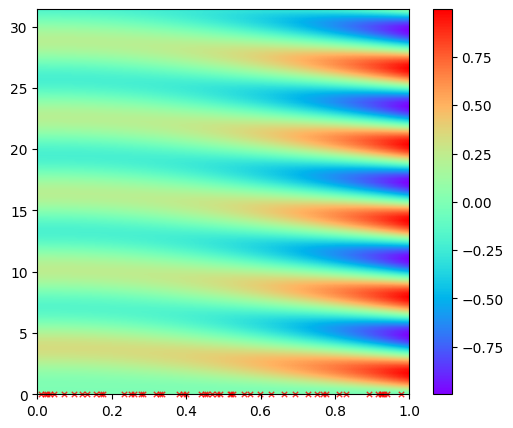

In [16]:
from utils.importer import *

class DataPreprocessor():

    def __init__(self, 
                 sol: dict,
                 frac: dict,
                 extent: np.ndarray,
                 N_f: int):
        
        ## Store the domain dimensions ##
        self.extent = extent

        ## Dictionary to store numerical solution data ##
        self.sol = sol
        
        ## Generate ground truth
        self.create_ground_truth()        
        
        ## Randomly pick data points for the training datasets ##
        self.traindata = {}
        self.create_train_dataset(frac, N_f)
        
    ## Function to create the ground truth over the domain from the numerical solver data
    def create_ground_truth(self):

        ## Exctract the data
        t = self.sol['t'].flatten()[:,None]
        x = self.sol['x'].flatten()[:,None]
        u = np.real(self.sol['u'])

        ## Create grid
        X, T = np.meshgrid(x,t)

        ## Compile the flattened grid and function values
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]

        ## Store the data
        self.ground_truth = {'inp': inp,
                             'out': out}
        
        ## Plot the ground truth
        fig, ax = plt.subplots(figsize=(6,5))
        im = ax.imshow(self.sol['u'], origin='lower', aspect='auto',
                       extent=np.asarray(self.extent).flatten(),
                       interpolation='bilinear', cmap='rainbow')
        fig.colorbar(im, ax=ax, location='right')

        ## Save the figure object
        self.ax = ax
        self.fig = fig

    
    ## Function to create dataset out of provided grid and function values
    def create_train_dataset(self, frac, N_f):
        
        ## Extract the exact solution ##
        data = self.sol
        t = data['t'].flatten()[:,None]
        x = data['x'].flatten()[:,None]
        u = np.real(data['u'])        
        
        ## Specify the number of points for boundaries ##
        N_ic = int(x.shape[0]*frac['ic'])
        N_bc = int(t.shape[0]*frac['bc'])
        N_d = int(u[1:,1:-1].shape[0]*frac['dom'])*int(u[1:,1:-1].shape[1]*frac['dom'])
        
        ## Create grid ##
        X, T = np.meshgrid(x,t)
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]     
        
        
        ## Start picking random points ##
            ## from initial condition
        train_ic = {}
        inp_ic = np.hstack((X[:1,:].T, T[:1,:].T))
        out_ic = u[:1,:].T
        idx_ic = np.random.choice(inp_ic.shape[0], N_ic, replace=False)
        train_ic.update({'inp': inp_ic[idx_ic, :], 
                         'out': out_ic[idx_ic, :]})
        self.ax.scatter(train_ic['inp'][:,0], train_ic['inp'][:,1], marker='x',
                        c = 'r', s=15, clip_on=False, alpha=0.8,
                        linewidth=1)
#             ## from left boundary condition
#         train_bcl = {}
#         inp_bcl = np.hstack((X[:,:1], T[:,:1]))
#         out_bcl = u[:,:1]
#         idx_bcl = np.random.choice(inp_bcl.shape[0], N_bc, replace=False)
#         train_bcl.update({'inp': inp_bcl[idx_bcl, :], 
#                           'out': out_bcl[idx_bcl, :]})  
#         self.ax.scatter(train_bcl['inp'][:,0], train_bcl['inp'][:,1], marker='x',
#                         c = 'r', s=15, clip_on=False, alpha=0.8,
#                         linewidth=1)
#             ## from right boundary condition
#         train_bcr = {}
#         inp_bcr = np.hstack((X[:,-1:], T[:,-1:]))
#         out_bcr = u[:,-1:]
#         idx_bcr = np.random.choice(inp_bcr.shape[0], N_bc, replace=False)
#         train_bcr.update({'inp': inp_bcr[idx_bcr, :], 
#                           'out': out_bcr[idx_bcr, :]})    
#         self.ax.scatter(train_bcr['inp'][:,0], train_bcr['inp'][:,1], marker='x',
#                         c = 'r', s=15, clip_on=False, alpha=0.8,
#                         linewidth=1)
#             ## from the domain
#         train_dom = {}
#         inp_dom = np.hstack((X[1:,1:-1].flatten()[:, None],
#                              T[1:,1:-1].flatten()[:, None]))
#         out_dom = u[1:,1:-1].flatten()[:,None]
#         idx_dom = np.random.choice(inp_dom.shape[0], N_d, replace=False)
#         train_dom.update({'inp': inp_dom[idx_dom, :], 
#                           'out': out_dom[idx_dom, :]})
#         self.ax.scatter(train_dom['inp'][:,0], train_dom['inp'][:,1], marker='.',
#                         c = 'r', s=15, clip_on=False, alpha=0.8, linewidth=1)
        
#             ## from the PDE
#         train_pde = {}
#         lb = inp.min(0)
#         ub = inp.max(0) 
#         inp_pde = lb + (ub-lb)*lhs(2, N_f)
#         train_pde.update({'inp': inp_pde})
#         self.ax.scatter(train_pde['inp'][:,0], train_pde['inp'][:,1], marker='+',
#                         c = 'r', s=15, clip_on=False, alpha=0.8, linewidth=1)
#             ## Package all the dictionaries into traindata
#         self.traindata.update({'ic': train_ic, 'bcl': train_bcl, 
#                                'bcr': train_bcr, 'dom': train_dom,
#                                'pde': train_pde})
        
NNdata = DataPreprocessor(numSol, frac, extent, N_f)

In [ ]:
from utils.importer import *

class DataPreprocessor():

    def __init__(self, 
                 sol: dict,
                 split: float,
                 frac: float,
                 extent: np.ndarray,
                 N_f: int):

        ## Store the domain dimensions
        self.extent = extent

        ## Dictionary to store data
        self.sol = sol
        
        ## Generate ground truth
        self.create_ground_truth()

        ## Split the dataset into test and train
        self.test_train_split(split)

        ## Randomly pick data points out of the train datasets ##
        self.traindata = {}
        self.create_train_dataset(frac, N_f)
        
        ## Collec points for the test datasets ##
        self.testdata = {}
        self.create_test_dataset()

        ## Show the plot and svae the figure
        plt.show()
        self.fig.savefig('results/groundtruth.png')
    
    ## Function to create dataset out of provided grid and function values
    def create_test_dataset(self):
        
        ## Extract the exact solution ##
        data = self.rawdata['test']
        t = data['t'].flatten()[:,None]
        x = data['x'].flatten()[:,None]
        u = np.real(data['u'])
        
        ## Create grid ##
        X, T = np.meshgrid(x,t)
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None] 
        
        ## Store the test dataset into the attribute dictinary ##
        self.testdata.update({'inp': inp, 'out': out})
    
        ## Plot the test data points ##
        self.ax.scatter(self.testdata['inp'][:,0], self.testdata['inp'][:,1], 
                        marker='.', c = 'k', s=15, clip_on=False, alpha=0.8,
                        linewidth=1)
    
    ## Function to create dataset out of provided grid and function values
    def create_train_dataset(self, frac, N_f):
        
        ## Extract the exact solution ##
        data = self.rawdata['train']
        t = data['t'].flatten()[:,None]
        x = data['x'].flatten()[:,None]
        u = np.real(data['u'])
        
        
        ## Specify the number of points for boundaries ##
        N_ic = int(x.shape[0]*frac)
        N_bc = int(t.shape[0]*frac)
        N_d = int(u[1:,1:-1].shape[0]*frac)*int(u[1:,1:-1].shape[1]*frac)
        
        ## Create grid ##
        X, T = np.meshgrid(x,t)
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]     
        
        
        ## Start picking random points ##
            ## from initial condition
        train_ic = {}
        inp_ic = np.hstack((X[:1,:].T, T[:1,:].T))
        out_ic = u[:1,:].T
        idx_ic = np.random.choice(inp_ic.shape[0], N_ic, replace=False)
        train_ic.update({'inp': inp_ic[idx_ic, :], 
                         'out': out_ic[idx_ic, :]})
        self.ax.scatter(train_ic['inp'][:,0], train_ic['inp'][:,1], marker='x',
                        c = 'r', s=15, clip_on=False, alpha=0.8,
                        linewidth=1)
            ## from left boundary condition
        train_bcl = {}
        inp_bcl = np.hstack((X[:,:1], T[:,:1]))
        out_bcl = u[:,:1]
        idx_bcl = np.random.choice(inp_bcl.shape[0], N_bc, replace=False)
        train_bcl.update({'inp': inp_bcl[idx_bcl, :], 
                          'out': out_bcl[idx_bcl, :]})  
        self.ax.scatter(train_bcl['inp'][:,0], train_bcl['inp'][:,1], marker='x',
                        c = 'r', s=15, clip_on=False, alpha=0.8,
                        linewidth=1)
            ## from right boundary condition
        train_bcr = {}
        inp_bcr = np.hstack((X[:,-1:], T[:,-1:]))
        out_bcr = u[:,-1:]
        idx_bcr = np.random.choice(inp_bcr.shape[0], N_bc, replace=False)
        train_bcr.update({'inp': inp_bcr[idx_bcr, :], 
                          'out': out_bcr[idx_bcr, :]})    
        self.ax.scatter(train_bcr['inp'][:,0], train_bcr['inp'][:,1], marker='x',
                        c = 'r', s=15, clip_on=False, alpha=0.8,
                        linewidth=1)
            ## from the domain
        train_dom = {}
        inp_dom = np.hstack((X[1:,1:-1].flatten()[:, None],
                             T[1:,1:-1].flatten()[:, None]))
        out_dom = u[1:,1:-1].flatten()[:,None]
        idx_dom = np.random.choice(inp_dom.shape[0], N_d, replace=False)
        train_dom.update({'inp': inp_dom[idx_dom, :], 
                          'out': out_dom[idx_dom, :]})
        self.ax.scatter(train_dom['inp'][:,0], train_dom['inp'][:,1], marker='.',
                        c = 'r', s=15, clip_on=False, alpha=0.8, linewidth=1)
        
            ## from the PDE
        train_pde = {}
        lb = inp.min(0)
        ub = inp.max(0) 
        inp_pde = lb + (ub-lb)*lhs(2, N_f)
        train_pde.update({'inp': inp_pde})
        self.ax.scatter(train_pde['inp'][:,0], train_pde['inp'][:,1], marker='+',
                        c = 'r', s=15, clip_on=False, alpha=0.8, linewidth=1)
            ## Package all the dictionaries into traindata
        self.traindata.update({'ic': train_ic, 'bcl': train_bcl, 
                               'bcr': train_bcr, 'dom': train_dom,
                               'pde': train_pde})
        
    ## Function to split the incoming dataset into test and train based on time
    def test_train_split(self, split):

        ## Define the index to split the dataset        
        nt = self.sol['t'].shape[0]
        idx_split = int(nt*split)

        ## store the test and train splits into dictionaries
        test = {}
        train = {}

        ## store time in test and train
        train['t'] = self.sol['t'][:idx_split+1]
        test['t'] = self.sol['t'][idx_split:]

        ## store time in test and train
        nx = self.sol['x'].shape[0]
        train['x'] = self.sol['x']
        test['x'] = self.sol['x']

        ## store solution in test and train
        train['u'] = self.sol['u'][:idx_split+1,:]
        test['u'] = self.sol['u'][idx_split:,:]

        ## Store the final splits into dictionary
        self.rawdata = {'train': train,
                        'test' : test}
        
        ## Plot the test train partition
        t_split = self.sol['t'][idx_split]
        x_test = self.sol['x'][int(0.4*nx)]
        x_train = self.sol['x'][int(0.6*nx)]
        self.ax.plot(self.sol['x'], t_split*np.ones((nx,1)), 'g--')
        self.ax.arrow(x_test, t_split, 0, 0.5, width=0.02, facecolor='r', alpha=1)
        self.ax.arrow(x_train, t_split, 0, -0.5, width=0.02, facecolor='k', alpha=1)
        self.ax.annotate('Test', xy=(x_test-0.05, t_split+0.7), fontsize=12, color = 'r')
        self.ax.annotate('Train', xy=(x_train-0.05, t_split-0.8), fontsize=12, color = 'k')


    ## Function to create the ground truth over the domain from the numerical solver data
    def create_ground_truth(self):

        ## Exctract the data
        t = self.sol['t'].flatten()[:,None]
        x = self.sol['x'].flatten()[:,None]
        u = np.real(self.sol['u'])

        ## Create grid
        X, T = np.meshgrid(x,t)

        ## Compile the flattened grid and function values
        inp = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
        out = u.flatten()[:,None]

        ## Store the data
        self.ground_truth = {'input': inp,
                             'output': out}
        
        ## Plot the ground truth
        fig, ax = plt.subplots(figsize=(6,5))
        im = ax.imshow(self.sol['u'], origin='lower', aspect='auto',
                       extent=np.asarray(self.extent).flatten(),
                       interpolation='bilinear', cmap='rainbow')
        fig.colorbar(im, ax=ax, location='right')

        ## Save the figure object
        self.ax = ax
        self.fig = fig



In [ ]:
## Prepare the dataset for training
NNdata = DataPreprocessor(numSol, split, frac, extent, N_domain)

**Setup the NN, train and save the weights**

In [ ]:
class PINN():
    def __init__(self, data, layers, diffusivity):

        ## gather train data ##
            ## Initial Condition ##
        self.xtrain_ic = torch.tensor(data.traindata['ic']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_ic = torch.tensor(data.traindata['ic']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_ic = torch.tensor(data.traindata['ic']['out']).float().to(device)        
            ## Boundary Condition Left ##
        self.xtrain_bcl = torch.tensor(data.traindata['bcl']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_bcl = torch.tensor(data.traindata['bcl']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_bcl = torch.tensor(data.traindata['bcl']['out']).float().to(device)   
            ## Boundary Condition Right ##
        self.xtrain_bcr = torch.tensor(data.traindata['bcr']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_bcr = torch.tensor(data.traindata['bcr']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_bcr = torch.tensor(data.traindata['bcr']['out']).float().to(device)   
            ## Domain data ##
        self.xtrain_dom = torch.tensor(data.traindata['dom']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_dom = torch.tensor(data.traindata['dom']['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utrain_dom = torch.tensor(data.traindata['dom']['out']).float().to(device)           
            ## PDE loss collocation points ##
        self.xtrain_pde = torch.tensor(data.traindata['pde']['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttrain_pde = torch.tensor(data.traindata['pde']['inp'][:, 1:2], requires_grad=True).float().to(device)

        ## gather test data

        self.xtest = torch.tensor(data.testdata['inp'][:, 0:1], requires_grad=True).float().to(device)
        self.ttest = torch.tensor(data.testdata['inp'][:, 1:2], requires_grad=True).float().to(device)
        self.utest = torch.tensor(data.testdata['out']).float().to(device)

        ## Assign layers
        self.layers = layers
        
        ## diffusivity ##
        self.diffusivity = diffusivity

        # deep neural networks
        self.dnn = DNN(layers).to(device)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(self.dnn.parameters(),
                                           lr=.1,
                                           max_iter=500,
                                           max_eval=500,
                                           history_size=50,
                                           tolerance_grad=1e-8,
                                           tolerance_change=1.0 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        self.iter = 0
        self.losses = {'train': [],
                       'train_ic': [],
                       'train_bcl': [],
                       'train_bcr': [],
                       'train_dom': [],
                       'train_pde': [],                       
                       'test': [],
                       'iter': []}

    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_dudx(self, x, t):
        
        u = self.net_u(x, t)
        dudx = torch.autograd.grad(u, x, 
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0]
        return dudx
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        dudt = torch.autograd.grad(u, t,
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0]        
        dudx = torch.autograd.grad(u, x,
                                   grad_outputs=torch.ones_like(u),
                                   retain_graph=True,
                                   create_graph=True)[0]
        ddudxx = torch.autograd.grad(dudx, x, 
                                     grad_outputs=torch.ones_like(dudx),
                                     retain_graph=True,
                                     create_graph=True)[0]
        f = dudt - self.diffusivity * ddudxx
        return f
    
    def loss_func(self):

        self.optimizer.zero_grad()

        ## Training Losses ##
            ## Initial condition ##
        uhat_ic = self.net_u(self.xtrain_ic, self.ttrain_ic)
        loss_ic = torch.mean((self.utrain_ic - uhat_ic) ** 2)
            ## Boundary condition left ##
        dudxhat_bcl = self.net_dudx(self.xtrain_bcl, self.ttrain_bcl)
        loss_bcl = torch.mean((dudxhat_bcl) ** 2)
            ## Boundary condition right ##
        uhat_bcr = self.net_u(self.xtrain_bcr, self.ttrain_bcr)
        loss_bcr = torch.mean((self.utrain_bcr - uhat_bcr) ** 2)        
            ## Data on the domain ##
        uhat_dom = self.net_u(self.xtrain_dom, self.ttrain_dom)
        loss_dom = torch.mean((self.utrain_dom - uhat_dom) ** 2)
            ## PDE loss on the collocation points ##
        pde_val = self.net_f(self.xtrain_pde, self.ttrain_pde)
        loss_pde = torch.mean(pde_val ** 2)
            ## Final loss ##
        loss_train = loss_ic + loss_bcl + loss_bcr + loss_dom + loss_pde
        
        ## Test Loss ##
        uhat_test = self.net_u(self.xtest, self.ttest)
        loss_test = torch.mean((self.utest - uhat_test) ** 2)


        loss_train.backward()
        self.iter += 1
        if self.iter % 10 == 0:
            self.losses['train'].append(loss_train.item())
            self.losses['train_ic'].append(loss_ic.item())
            self.losses['train_bcl'].append(loss_bcl.item())
            self.losses['train_bcr'].append(loss_bcr.item())
            self.losses['train_dom'].append(loss_dom.item())
            self.losses['train_pde'].append(loss_pde.item())
            self.losses['test'].append(loss_test.item())
            self.losses['iter'].append(self.iter)
            print(
                'Iter %d, Loss train: %.5e, Loss test: %.5e' % (self.iter, loss_train.item(), loss_test.item())
            )
        return loss_train

    def train(self):
        self.dnn.train()

        # Backward and optimize
        self.optimizer.step(self.loss_func)

        ## Plot the losses
        fig, ax = plt.subplots(figsize=(6,5))
        ax.plot(self.losses['iter'], self.losses['train'], label='train')
        ax.plot(self.losses['iter'], self.losses['train_ic'], label='IC')        
        ax.plot(self.losses['iter'], self.losses['train_bcl'], label='BC left')  
        ax.plot(self.losses['iter'], self.losses['train_bcr'], label='BC right')  
        ax.plot(self.losses['iter'], self.losses['train_dom'], label='Data')
        ax.plot(self.losses['iter'], self.losses['train_pde'], label='pde')
        ax.plot(self.losses['iter'], self.losses['test'], label='test')
        ax.set_yscale('log')
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss')
        ax.legend()
        plt.savefig('results/losses.png')

In [ ]:
model = PINN(NNdata, layers, diffusivity)
if os.path.isfile('saved/trained_parameters'):
    model.dnn.load_state_dict(torch.load('saved/trained_parameters', map_location=torch.device('cpu')))
else:
    model.train()
    torch.save(model.dnn.state_dict(), 'saved/trained_parameters')

**Run the predictions**

In [ ]:
model.predict(NNdata, [0, 0.25, 0.50, 0.75, 0.999], split, extent)